# Splunk App for Data Science and Deep Learning - A Threat Hunting Notebook Example to Explore Anomalous Activities in Windows Event Logs

This notebook contains a simple example for a threat hunting approach with the Splunk App for Data Science and Deep Learning (DSDL) - formerly known as the Deep Learning Toolkit for Splunk (DLTK). Find more examples and information in the app and on the [DSDL splunkbase page](https://splunkbase.splunk.com/app/4607/#/details).

In the context of the [PEAK framework](https://www.splunk.com/en_us/blog/security/peak-threat-hunting-framework.html) this notebook can serve as a example starting point for a [Model Assisted Threat Hunting](https://www.splunk.com/en_us/blog/security/peak-framework-math-model-assisted-threat-hunting.html) approach as described by Ryan Fetterman, David Bianco and the wider SURGe team.

Note: By default every time you save this notebook the stages main cells are exported into a python module which can then get invoked by Splunk's MLTK SPL commands like <code> | fit ... | apply ... | summary </code>. Please read the [model workflow documentation](https://docs.splunk.com/Documentation/DSDL/latest/User/ModelWorkflow) for more information about this workflow.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [1]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
import os

# for operationalization of the model we want to use a few other libraries later
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest

# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [2]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.26.4
pandas version: 2.2.0


## Stage 1 - get a data sample from Splunk
Please make sure you have the botsv3 sample dataset available in Splunk in an `index=botsv3` . You can find it here: [https://github.com/splunk/botsv3](https://github.com/splunk/botsv3)

### Get data from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. You utilize the `mode=stage` flag in the in the `| fit` command to do this. The search results are accessible then as csv file with the same model name that is defined in the `into app:<modelname>` part of the fit statement. Additionally, meta data is retrieved and accessible as json file. In the same way you can further work with the meta data object as it is exposed in the fit and apply function definitions below in stage 3 and 4.

index=botsv3 source="*WinEventLog:Security" <br>
| bin _time span=1h <br>
| fillnull value=unknown Account_Name <br>
| stats count by _time ComputerName Account_Name EventCode <br>
| fit MLTKContainer mode=stage algo=a_threat_hunting_notebook _time ComputerName Account_Name EventCode count into app:a_threat_hunt_model<br>

#### Explanation what the SPL does
1. we access data from the botsv3 index and select only Windows Security Event Log data
2. we arrange the data into buckets of 1 hour for later transformation with | stats
3. we fill missing field values in the Account_Name with the value "unknown" to avoid NULL values
4. we run a statistical aggregation and count for each 1h bucket how many ComputerName Account_Name and EventCode combinations have occurred
5. we stage the data into the container and specify the fields we want to work with and give a model name that we can reference in the next section

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("barebone_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [3]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [4]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("a_threat_hunt_model")

#### Explore the parameters object param
This object can contain any additional parameters or controls you want to express in SPL and dynamically use in this notebook or operationalized python modules 

In [5]:
param

{'options': {'params': {'mode': 'stage', 'algo': 'a_threat_hunting_notebook'},
  'args': ['_time', 'ComputerName', 'Account_Name', 'EventCode', 'count'],
  'feature_variables': ['_time',
   'ComputerName',
   'Account_Name',
   'EventCode',
   'count'],
  'model_name': 'a_threat_hunt_model',
  'algo_name': 'MLTKContainer',
  'mlspl_limits': {'disabled': False,
   'handle_new_cat': 'default',
   'max_distinct_cat_values': '10000',
   'max_distinct_cat_values_for_classifiers': '10000',
   'max_distinct_cat_values_for_scoring': '10000',
   'max_fit_time': '6000',
   'max_inputs': '10000000',
   'max_memory_usage_mb': '16000',
   'max_model_size_mb': '3000',
   'max_score_time': '6000',
   'use_sampling': '1'},
  'kfold_cv': None},
 'feature_variables': ['_time',
  'ComputerName',
  'Account_Name',
  'EventCode',
  'count']}

#### Explore the pandas dataframe df

In [6]:
df

,_time,ComputerName,Account_Name,EventCode,count
0,1534755600,ABUNGST-L.froth.ly,-,4688,319
1,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4616,1
2,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4624,4
3,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4627,4
4,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4663,1
...,...,...,...,...,...
1090,1534777200,PCERF-L.froth.ly,PeatCerf,4689,45
1091,1534777200,PCERF-L.froth.ly,PeatCerf,5061,1
1092,1534777200,PCERF-L.froth.ly,SYSTEM,4624,6
1093,1534777200,PCERF-L.froth.ly,SYSTEM,4627,6


You can utilize any standard techniques and methods to explore the dataframe and conduct any derived analysis steps with the libraries and functions of your choice, e.g. get a simple summary with the describe() function:

In [7]:
df.describe()

,_time,EventCode,count
count,1.095000e+03,1095.000000,1095.000000
mean,1.534765e+09,4740.897717,50.022831
std,7.134903e+03,365.640270,177.517526
min,1.534756e+09,1100.000000,1.000000
25%,1.534759e+09,4663.000000,3.000000
50%,1.534763e+09,4673.000000,7.000000
75%,1.534770e+09,4689.000000,40.000000
max,1.534777e+09,8222.000000,2862.000000


#### Visualize the dataframe
You can use different visualization tools to explore the dataframe inline in the Juypter notebook. The first example shows a simple quick matplotlib scatter chart:

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline

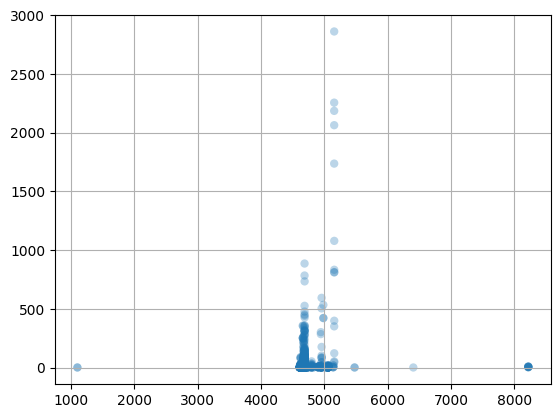

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['EventCode'], df['count'], alpha=0.3, edgecolors='none')
ax.grid(True)
plt.show()

In the scatterplot above we can see how the different EventCodes on the x-axis are used more or less frequently on the y-axis. There is already a specific pattern visible that we can further explore.
We can also use other visualization libraries like [seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html):

In [10]:
import seaborn as sns

<Axes: xlabel='EventCode', ylabel='count'>

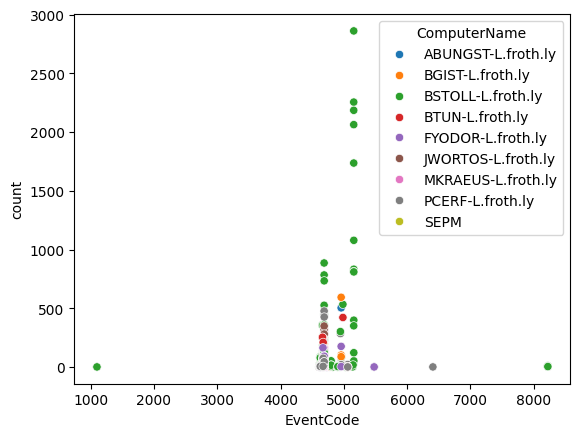

In [11]:
sns.scatterplot(data=df, x="EventCode", y="count", hue="ComputerName")

In this scatterplot we can color code the ComputerNames and see which of them are associated with what parts of the plot.

Note that you can also utilize SPL and the various visualization options and charts on a splunk dashboard. Many of them allow for more interactivity and also allow to define drill-downs on a dashboard. Note that you can also embed any python generated charts back into a Splunk dashboard using the DSDL graphics endpoint which is used for example in the `correlation_matrix` or `ja3_encoder` notebooks.

## Stage 2 - create and initialize a model
In this section we want to build a simple model that attempts to find anomaleous logins using an Isolation Forest. Before we use the [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) we use a simple [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to prepare the features of interest. We define the key components in the `init` method which takes the dataframe and the parameter object from above. The same is later done during operationalization when the model is initialized the first time, e.g. before the first training run.

In [12]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = {}
    model['encoder'] = OneHotEncoder(handle_unknown='ignore')
    model['detector'] = IsolationForest(contamination=0.01)
    return model

In [13]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
model = init(df,param)
print(model)

{'encoder': OneHotEncoder(handle_unknown='ignore'), 'detector': IsolationForest(contamination=0.01)}


### Rapidly prototype the different parts of the model
We can interactively step through the different parts of the model and debug and adjust at every step if needed

#### One Hot Encoding

In [14]:
# we define the relevant features we want to use for the one hot encoding:
features_to_encode = df[['ComputerName','EventCode']]
features_to_encode

,ComputerName,EventCode
0,ABUNGST-L.froth.ly,4688
1,ABUNGST-L.froth.ly,4616
2,ABUNGST-L.froth.ly,4624
3,ABUNGST-L.froth.ly,4627
4,ABUNGST-L.froth.ly,4663
...,...,...
1090,PCERF-L.froth.ly,4689
1091,PCERF-L.froth.ly,5061
1092,PCERF-L.froth.ly,4624
1093,PCERF-L.froth.ly,4627


In [15]:
# we fit the OneHotEncoder to the data 
model['encoder'].fit(features_to_encode)

OneHotEncoder(handle_unknown='ignore')

In [16]:
model['encoder'].categories_

[array(['ABUNGST-L.froth.ly', 'BGIST-L.froth.ly', 'BSTOLL-L.froth.ly',
        'BTUN-L.froth.ly', 'FYODOR-L.froth.ly', 'JWORTOS-L.froth.ly',
        'MKRAEUS-L.froth.ly', 'PCERF-L.froth.ly', 'SEPM'], dtype=object),
 array([1100, 4608, 4610, 4611, 4614, 4616, 4622, 4624, 4625, 4627, 4634,
        4647, 4648, 4659, 4660, 4663, 4664, 4670, 4672, 4673, 4674, 4688,
        4689, 4696, 4697, 4720, 4722, 4724, 4728, 4732, 4738, 4776, 4797,
        4799, 4826, 4902, 4904, 4905, 4944, 4945, 4946, 4948, 4950, 4953,
        4956, 4957, 4985, 5024, 5031, 5033, 5058, 5059, 5061, 5140, 5142,
        5145, 5156, 5157, 5478, 6406, 8222])]

In [17]:
# and we apply the transform to investigate the results, a sparse matrix of the encoding
encoded_features = model['encoder'].transform(features_to_encode)
encoded_features

<1095x70 sparse matrix of type '<class 'numpy.float64'>'
	with 2190 stored elements in Compressed Sparse Row format>

In [18]:
# to better understand how the one hot encoding matrix looks like we can convert to a pandas dataframe
pd.DataFrame(encoded_features.toarray())

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# to understand how those features would translate back to our main dataframe let's create a combined one:
df_encoded = pd.concat([df, pd.DataFrame(encoded_features.toarray())], axis=1)
df_encoded

,_time,ComputerName,Account_Name,EventCode,count,0,1,2,3,4,...,60,61,62,63,64,65,66,67,68,69
0,1534755600,ABUNGST-L.froth.ly,-,4688,319,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4616,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4624,4,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4627,4,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1534755600,ABUNGST-L.froth.ly,ABUNGST-L$,4663,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,1534777200,PCERF-L.froth.ly,PeatCerf,4689,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,1534777200,PCERF-L.froth.ly,PeatCerf,5061,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,1534777200,PCERF-L.froth.ly,SYSTEM,4624,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,1534777200,PCERF-L.froth.ly,SYSTEM,4627,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# here we want to add another feature column and also make sure all the column names are string types - otherwise isolation forest will complain
df_encoded_features = pd.concat([df[['count']], pd.DataFrame(encoded_features.toarray()).add_prefix('f_')], axis=1)
df_encoded_features

,count,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69
0,319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Isolation Forest
Apply an isolation forest to our selected featureset

In [21]:
# let's see how an isolation forest can be applied on the one hot encoded matrix 
model['detector'].fit(df_encoded_features)

IsolationForest(contamination=0.01)

In [22]:
# we apply the isolation forest detector on the same and get an array of outliers returned. By definition -1 are outliers.
outliers = model['detector'].predict(df_encoded_features)
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
# we convert to a dataframe and sum up how many outliers have been detected.
# note that the contamination value of 0.01 controls the amount of detected outliers.
# in our case we have a dataset with 1095 rows, so 1% of that is roughly 10 or 11 what we can expect as the calculated sum
df_outliers = pd.DataFrame(outliers)
df_outliers[df_outliers[0]<0].sum().abs()[0]

9

In [24]:
# we combine the found outliers with the main dataframe
df_results = pd.concat([df, df_outliers.rename(columns={0: 'outlier'})], axis=1)
# and we can only display the rows which were flagged as outliers with -1
df_results[df_results['outlier']<0]

,_time,ComputerName,Account_Name,EventCode,count,outlier
20,1534755600,ABUNGST-L.froth.ly,unknown,4957,504,-1
189,1534755600,PCERF-L.froth.ly,PCERF-L$,4799,16,-1
227,1534755600,SEPM,SEPM$,4799,2,-1
247,1534759200,BGIST-L.froth.ly,BGIST-L$,4611,1,-1
344,1534759200,FYODOR-L.froth.ly,unknown,4957,176,-1
433,1534762800,BGIST-L.froth.ly,BGIST-L$,4799,2,-1
579,1534766400,BGIST-L.froth.ly,BGIST-L$,4799,2,-1
590,1534766400,BGIST-L.froth.ly,unknown,4957,594,-1
673,1534770000,BGIST-L.froth.ly,BGIST-L$,4799,2,-1


Note that we can interate on all the development steps above to find the right model and tuning. Once we are finished, we can put this into an operational model by completing the fit and apply stages below. Please also note, that the isolation forest used above is not deterministic as it involves random trees, therefore the found outliers likely change after each run.

### Visualize the model results
Let's visualize the results to understand where outliers have been found and see it at a glance.

<Axes: xlabel='EventCode', ylabel='count'>

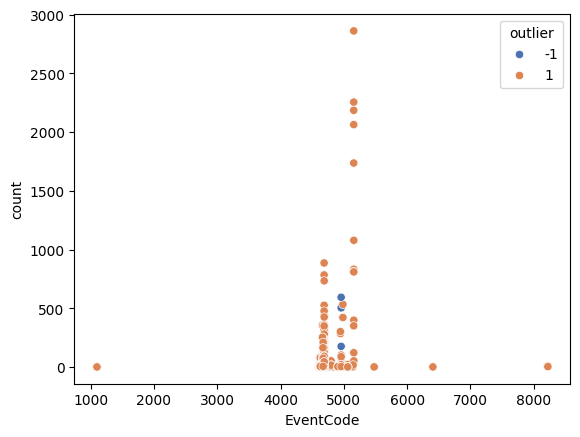

In [25]:
sns.scatterplot(data=df_results, x="EventCode", y="count", hue="outlier", palette="deep")

## Stage 3 - fit the model
Based on our steps developed above we can insert the key parts in the fit method which will get used for operationalization via SPL with `| fit`

In [26]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    features_to_encode = df[['ComputerName','EventCode']]
    model['encoder'].fit(features_to_encode)
    encoded_features = model['encoder'].transform(features_to_encode)
    df_encoded_features = pd.concat([df[['count']], pd.DataFrame(encoded_features.toarray()).add_prefix('f_')], axis=1)
    model['detector'].fit(df_encoded_features)
    info = {"message": "model trained"}
    return info

In [27]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(fit(model,df,param))

{'message': 'model trained'}


## Stage 4 - apply the model
Based on our steps developed above we can insert the key parts also in the apply method which will get used for operationalization via SPL with `| apply`


In [28]:
# apply your model
# returns the calculated results
def apply(model,df,param):
    features_to_encode = df[['ComputerName','EventCode']]
    encoded_features = model['encoder'].transform(features_to_encode)
    df_encoded_features = pd.concat([df[['count']], pd.DataFrame(encoded_features.toarray()).add_prefix('f_')], axis=1)
    outliers = model['detector'].predict(df_encoded_features)
    result = pd.DataFrame(outliers, columns=['outlier'])
    return result

In [29]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(apply(model,df,param))

      outlier
0           1
1           1
2           1
3           1
4           1
...       ...
1090        1
1091        1
1092        1
1093        1
1094        1

[1095 rows x 1 columns]


## Stage 5 - save the model

In [30]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    # we skip saving and loading in this example, but of course you can build your preferred serialization here
    #with open(MODEL_DIRECTORY + name + ".json", 'w') as file:
    #    json.dump(model, file)
    return model

## Stage 6 - load the model

In [31]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    # we skip saving and loading in this example, but of course you can build your preferred deserialization here
    model = {}
    #with open(MODEL_DIRECTORY + name + ".json", 'r') as file:
    #    model = json.load(file)
    return model

## Stage 7 - provide a summary of the model

In [32]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

## Conclusion
This notebook shows a simple example how a model based threat hunting exercise can look like. Needless to say that you can extend the complexity and sophistication of such a notebook as required. Most importantly you can also directly make use of your models from splunk search and use the results for alerting, reporting or dashboard integration. You can run the following search to get a simple report on what ComputerNames have been indentified with the most anomalies and get a ranked list of scores than can be a starting point for further investigations.

index=botsv3 source="*WinEventLog:Security" <br>
| bin _time span=1h <br>
| fillnull value=unknown Account_Name <br>
| stats count by _time ComputerName Account_Name EventCode <br>
| fit MLTKContainer algo=a_threat_hunting_notebook _time ComputerName Account_Name EventCode count into app:a_threat_hunt_model <br>
| where predicted_outlier<0 <br>
| eval predicted_outlier = abs(predicted_outlier) <br>
| stats sum(predicted_outlier) as anomaly_score by ComputerName <br>
| sort -anomaly_score <br>


The results in Splunk should look similar to the data frame below. We have a sorted list of ComputerName with their summed anomaly_score in descending order. Note that the actual ComputerName and anomaly_score can look different when you run it as the IsolationForest is not deterministic as explained above.

In [33]:
pd.DataFrame([{"ComputerName":"BSTOLL-L.froth.ly", "anomaly_score":"8"}, {"ComputerName":"ABUNGST-L.froth.ly", "anomaly_score":"1"}, {"ComputerName":"BGIST-L.froth.ly", "anomaly_score":"1"}, {"ComputerName":"SEPM", "anomaly_score":"1"}])

,ComputerName,anomaly_score
0,BSTOLL-L.froth.ly,8
1,ABUNGST-L.froth.ly,1
2,BGIST-L.froth.ly,1
3,SEPM,1


## End of Stages
All subsequent cells are not tagged and can be used for further freeform code